In [14]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import sys
sys.path.append('/content/drive/MyDrive')

In [16]:
!cp '/content/drive/MyDrive/Data.zip' .
!unzip -q Data.zip
!rm Data.zip

replace Data/s01/01.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace Data/s01/02.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [42]:
# Import Keras and other Deep Learning dependencies
from keras.models import Sequential
import time
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
import seaborn as sns
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.regularizers import l2
import keras as K
import cv2
import os
from skimage import io
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import numpy.random as rng
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
import keras


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
impath=[]
directory = 'Data'
label=[]
i=0
for file_name in os.listdir(directory):
    sub_dir_path = directory + '/' + file_name
    if (os.path.isdir(sub_dir_path)):
        for image_name in os.listdir(sub_dir_path):
            if image_name[-4:] == '.jpg':
                image_path = directory + '/' + file_name+'/'+image_name
                impath.append(image_path)
                label.append(i)
    i=i+1
print("Total number of images in the training set: ", len(impath))

Total number of images in the training set:  689


In [20]:
x_train=[]

from PIL import Image
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
for path in impath:
    img = Image.open(path)
    img= img.resize((128,128))
    img = img_to_array(img).astype('float32')/255.
    x_train.append(img)

In [21]:
x_train= np.array(x_train)
print("Size of X : ", x_train.shape)

Size of X :  (689, 128, 128, 3)


In [22]:

    
labels=np.array(label)   
#labels=labels.reshape(len(label),1)
print(labels[:20])



[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]


In [23]:
def make_pairs(images, labels):
    # initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive or negative
    pairImages = []
    pairLabels = []
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
    #print(idx)
    # loop over all images
    for idxA in range(len(images)):
        # grab the current image and label belonging to the current
        # iteration
        currentImage = images[idxA]
        label = labels[idxA]
        #print(label)
        # randomly pick an image that belongs to the *same* class
        # label
        for i in range(2):
            idxB = np.random.choice(idx[label])
            posImage = images[idxB]
            # prepare a positive pair and update the images and labels
            # lists, respectively
            pairImages.append([currentImage, posImage])
            pairLabels.append([1])
            # grab the indices for each of the class labels *not* equal to
            # the current label and randomly pick an image corresponding
            # to a label *not* equal to the current label
            negIdx = np.where(labels != label)[0]
            negImage = images[np.random.choice(negIdx)]
            # prepare a negative pair of images and update our lists
            pairImages.append([currentImage, negImage])
            pairLabels.append([0])
    # return a 2-tuple of our image pairs and labels
    return (np.array(pairImages), np.array(pairLabels))

In [24]:
X,Y= make_pairs(x_train,labels)

In [25]:
from sklearn.utils import shuffle
X,Y=shuffle(X,Y)

<Figure size 720x720 with 0 Axes>

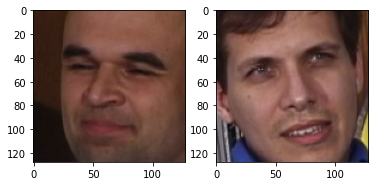

<Figure size 720x720 with 0 Axes>

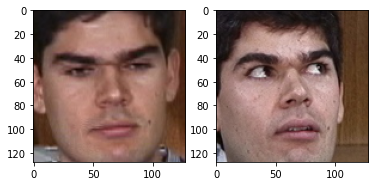

<Figure size 720x720 with 0 Axes>

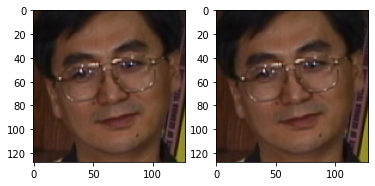

<Figure size 720x720 with 0 Axes>

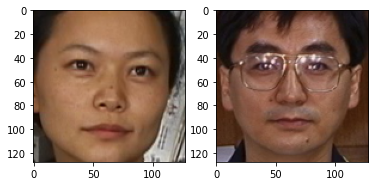

<Figure size 720x720 with 0 Axes>

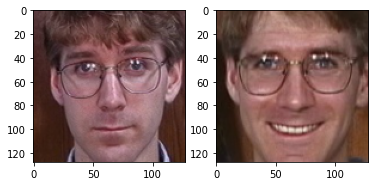

<Figure size 720x720 with 0 Axes>

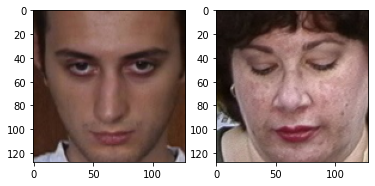

<Figure size 720x720 with 0 Axes>

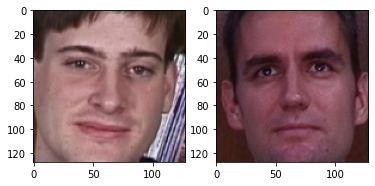

<Figure size 720x720 with 0 Axes>

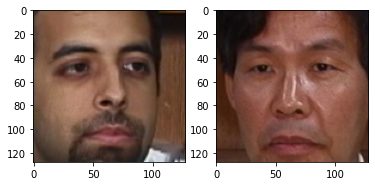

<Figure size 720x720 with 0 Axes>

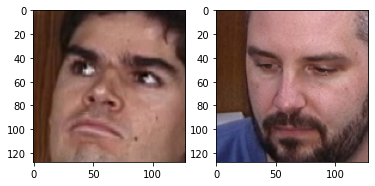

<Figure size 720x720 with 0 Axes>

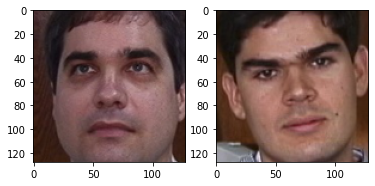

[[0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]]


In [26]:

for i in range(10):
  plt.figure(figsize=(10,10))
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(X[i][0])
  axarr[1].imshow(X[i][1])
  plt.show()


print(Y[:20])

In [27]:
c=0
for i in range(len(Y)):
  if Y[i]==1:
    c+=1
print(c)
print(len(Y))

1378
2756


In [29]:
X_train=X[:2000]
Y_train=Y[:2000].astype(np.float32)
Y_test=Y[2000:].astype(np.float32)
X_test=X[2000:]
X_train.dtype

dtype('float32')

In [30]:
print(X.shape)

(2756, 2, 128, 128, 3)


In [31]:
input_shape=(128,128,3)

In [32]:
def contrastive_loss(y, d):
    """ Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    margin = 1
    return K.mean(y * K.square(d) + (1 - y) * K.square(K.maximum(margin - d, 0)))


In [37]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    initailizer= keras.initializers.RandomNormal()
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu',padding='same', input_shape=input_shape,kernel_initializer=initailizer, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D((2,2), padding='same'))
    model.add(Conv2D(128, (7,7), activation='relu',padding='same',kernel_initializer=initailizer, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D((2,2), padding='same'))
    model.add(Conv2D(256, (4,4), activation='relu',padding='same', kernel_initializer=initailizer, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D((2,2), padding='same'))
    model.add(Conv2D(512, (4,4), activation='relu',padding='same', kernel_initializer=initailizer, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D((2,2), padding='same'))
    model.add(Conv2D(1024, (2,2), activation='relu',padding='same', kernel_initializer=initailizer, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D((2,2), padding='same'))
    model.add(Conv2D(1024, (2,2), activation='relu',padding='same', kernel_initializer=initailizer, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D((2,2), padding='same'))
    model.add(Conv2D(2048, (2,2), activation='relu',padding='same', kernel_initializer=initailizer, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid', kernel_regularizer=l2(1e-3), kernel_initializer=initailizer))
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:tf.keras.backend.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    return siamese_net

In [45]:
from tensorflow.keras.optimizers import RMSprop
S_net= get_siamese_model(input_shape)
optimizer = RMSprop(lr = 0.0006)
S_net.compile(loss='binary_crossentropy',optimizer=optimizer)
S_net.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_8 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_2 (Sequential)      (None, 4096)         51285696    ['input_7[0][0]',                
                                                                  'input_8[0][0]']          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
b_size=32
S_net.fit(x=[X_train[:,0],X_train[:,1]],y= Y_train, epochs=400,batch_size=b_size)

In [50]:
#X_test.shape
#X_test[0][0].shape
out=S_net.predict(x=[X_test[:,0],X_test[:,1]])
for i in range(len(out)):
  if out[i]>0.3:
    out[i]=1
  else:
    out[i]=0
out.shape
print(out[5:15])
print(Y_test[5:15])

[[1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [51]:
test=np.array(out)
from sklearn.metrics import accuracy_score
acc=accuracy_score(test,Y_test)
print(acc)

0.8941798941798942


In [53]:
S_net.save('/content/drive/MyDrive/models/facerecognitionbc')
S_net.save('/content/drive/MyDrive/models/facerecognitionbc.h5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/facerecognitionbc/assets
